In [342]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
warnings.filterwarnings('ignore')
from scipy import stats
from datetime import datetime
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [343]:
df = pd.read_csv('../Phase2Project/data/kc_house_data_train.csv')
pd.set_option('display.max_columns', None)
df = df.drop('Unnamed: 0', axis=1)

# Data Cleaning

In [344]:
df.isna().sum() #no missing values

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [345]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [346]:
df['price'].mean()

540739.5486408329

In [347]:
df['bathrooms'].value_counts()

2.50    4322
1.00    3100
1.75    2431
2.25    1666
2.00    1549
1.50    1168
2.75     896
3.00     592
3.50     591
3.25     455
3.75     135
4.00     107
4.50      76
4.25      64
0.75      52
5.00      17
4.75      16
5.25      11
0.00       8
5.50       7
1.25       6
6.00       6
5.75       3
0.50       3
8.00       2
6.75       2
6.25       2
7.50       1
6.50       1
7.75       1
Name: bathrooms, dtype: int64

Bathrooms with a value less than 0.75 do not include a shower, therefore must be faulty data. Let's impute these rows with the median bathroom value.

In [348]:
df['bathrooms'] = df['bathrooms'].replace(to_replace=[0,.05], value=df['bathrooms'].median())


In [349]:
df['bedrooms'].value_counts()

3     7864
4     5488
2     2204
5     1283
6      229
1      160
7       30
0       12
8       10
9        5
10       3
11       1
33       1
Name: bedrooms, dtype: int64

One bedroom in particular has a value of 33. Looking at other houses with 3 bedrooms, this row seems to match other variable values. Let's assume 33 was a type and change the value to 3.

In [350]:
df['bedrooms'] = df['bedrooms'].replace(to_replace=33, value=3)

Let's also convert date column to datetime object so we can do EDA with it later.

In [351]:
def convert_dt(obj):
    obj = obj[0:8]
    date_time_obj=datetime.strptime(obj, '%Y%m%d' )
    return date_time_obj

In [352]:
df['date'] = df['date'].map(convert_dt)

# Exploratory Data Anaylsis

Let's plot our longitutude and latitude coordinates to get a sense of our property locations.

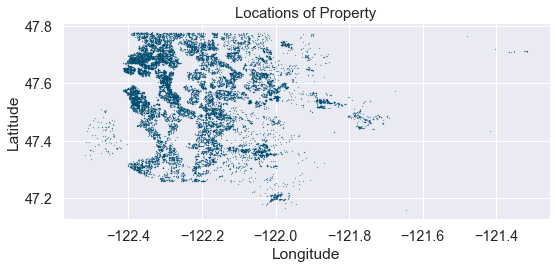

In [353]:
# overall region plot
plt.figure(figsize = (8,4))
ax = plt.subplot(1,1,1)
plt.plot(df['long'], df['lat'], 'o', markersize = 0.2, color = '#004c70')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Locations of Property', fontsize = 15)

plt.tight_layout()

In [354]:
df['price'].describe()

count    1.729000e+04
mean     5.407395e+05
std      3.733190e+05
min      7.500000e+04
25%      3.210000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

Text(0.5, 0, 'Price')

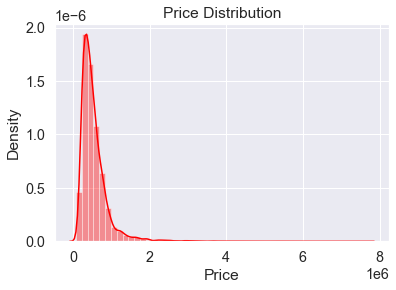

In [355]:
#check the distribution
sns.distplot(df['price'], color = 'red')
# plt.xticks(rotation=90);
plt.title('Price Distribution')
plt.xlabel('Price')

We can see our price data is skewed right and is not normally distributed.

Text(0, 0.5, 'Price')

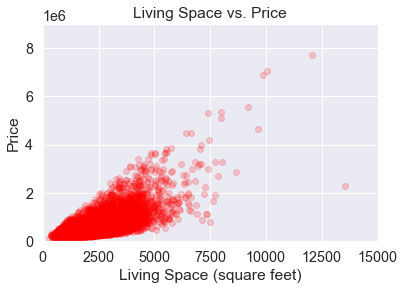

In [356]:
fig, ax = plt.subplots()
ax.scatter(df['sqft_living'],df['price'],c ='red',alpha = 0.18)
ax.set_xlim(0,15000)
ax.set_ylim(0,9000000)
ax.set_title('Living Space vs. Price')
ax.set_xlabel('Living Space (square feet)')
ax.set_ylabel('Price')

Plotting living space vs. price, we can see there are many outliers. We can try multiplying values greater than 7000 by .60 to scale them down.

In [357]:
df.loc[df["sqft_living"]>5000, "sqft_living"] = df['sqft_living']*.65

Text(0, 0.5, 'Price')

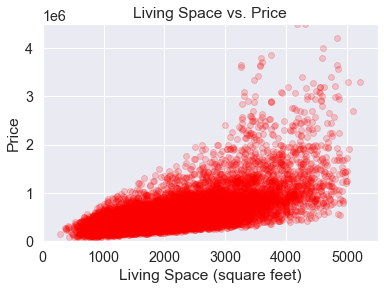

In [358]:
fig, ax = plt.subplots()
ax.scatter(df['sqft_living'],df['price'],c ='red',alpha = 0.18)
ax.set_xlim(0,5500)
ax.set_ylim(0,4500000)
ax.set_title('Living Space vs. Price')
ax.set_xlabel('Living Space (square feet)')
ax.set_ylabel('Price')

This looks a little better compared to before.

Text(0, 0.5, 'Price')

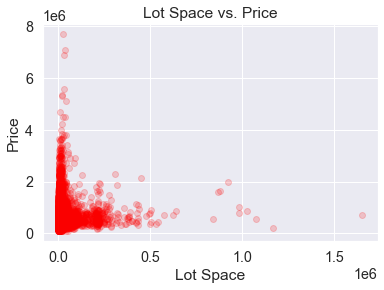

In [359]:
fig, ax = plt.subplots()
ax.scatter(df['sqft_lot'],df['price'],c ='red',alpha = 0.18)

ax.set_title('Lot Space vs. Price')
ax.set_xlabel('Lot Space')
ax.set_ylabel('Price')

We can see that Lot Space does not have as important of an effect on Price that Living Space does, so we may consider not using this variable for the model.

Text(0, 0.5, 'Price')

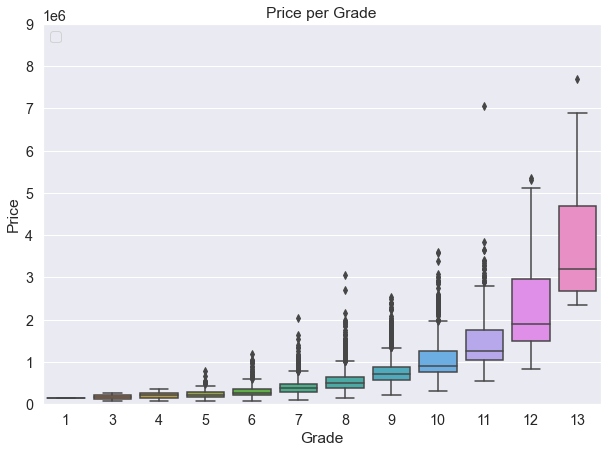

In [360]:
fig, ax = plt.subplots(figsize=(10, 7))
fig = sns.boxplot(x='grade', y="price",hue='grade', data=df ,dodge=False)
fig.legend('',loc =2)
fig.axis(ymin=0, ymax=9000000);
plt.title('Price per Grade')
plt.xlabel('Grade')
plt.ylabel('Price')


It appears that as the grade of a house goes up, the price increases as well.

Text(0.5, 1.0, 'Correlation Heat Map')

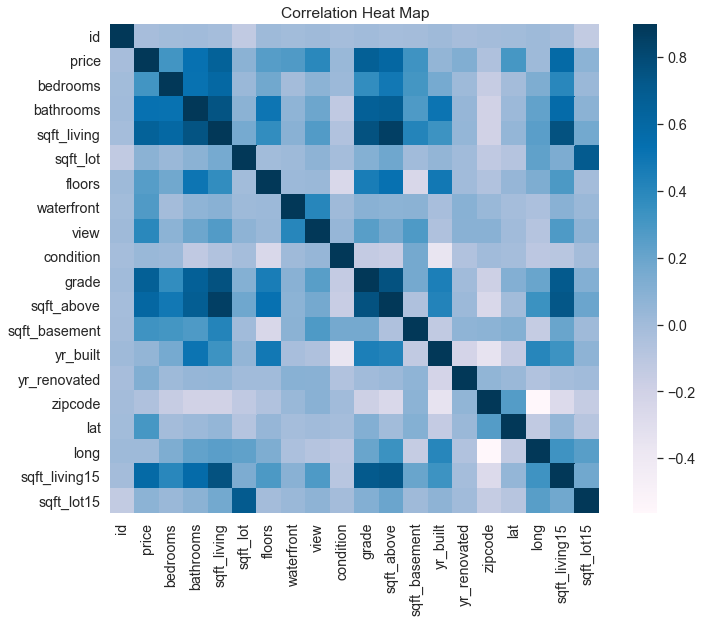

In [361]:
corrmat = df.corr()
fig, ax = plt.subplots(figsize=(12, 9))
heatm = sns.heatmap(corrmat, vmax=0.9, square=True, cmap = 'PuBu');
ax.set_title('Correlation Heat Map')

This correlation heat map gives a good sense of which variables have issues of multicollinearity (ex: sqft_above and sqft_living). Additionally, we can also see which variables have a greater impact on price (sqft_living and grade). We may be able to visualize clearer if we focus on the top correlations to price.

Text(0.5, 1.0, 'Heat Map with Largest Correlation to Price')

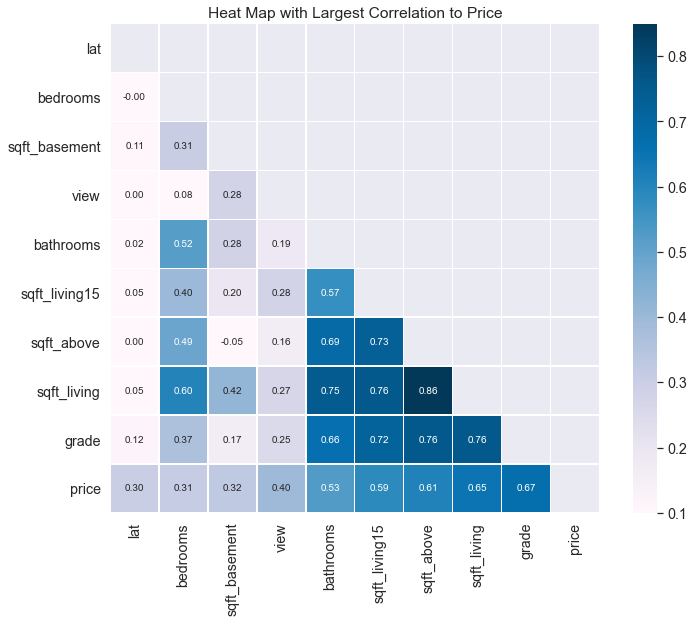

In [362]:
#saleprice correlation matrix
n = 10 #number of parameters for heatmap
cols = corrmat.nlargest(n, 'price')['price'].index
cols2 = np.array(list(reversed(cols)))
cm = df[cols2].corr()
# mask to get only the upper triangle of the matrix, as the lower one is just repeated information
mask = np.triu(np.ones_like(cm, dtype=np.bool))
# adjust mask and df

cm2 = cm.iloc[1:,:-1].copy()
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.3)
heatmap = sns.heatmap(cm,mask=mask, cbar=True, annot=True, square=True, cmap = 'PuBu', fmt='.2f', vmin=.1, vmax=.85,linewidth=0.3, annot_kws={'size': 10}, yticklabels=cols2, xticklabels=cols2)
ax.set_title('Heat Map with Largest Correlation to Price')


Text(0, 0.5, 'Frequency')

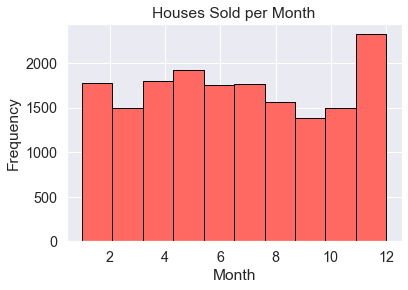

In [363]:
month_sold = df['date'].dt.month
fig, ax = plt.subplots()
ax.hist(month_sold, color='#ff6961',edgecolor='black')
ax.set_title('Houses Sold per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Price')

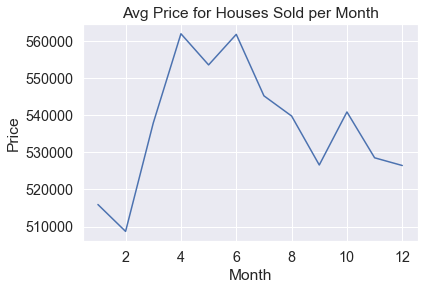

In [364]:
month_price = df.groupby(df['date'].dt.month).agg('mean')['price']
fig, ax = plt.subplots()
ax.plot(month_price.index,month_price.values)
ax.set_title('Avg Price for Houses Sold per Month')
ax.set_xlabel('Month')
ax.set_ylabel('Price')

Date does not seem to have a large impact on when the house was sold. There seems to be a peak in April, but we would need more years of data to make a conclusion. We might exclude this from the model.

Text(0, 0.5, 'Frequency')

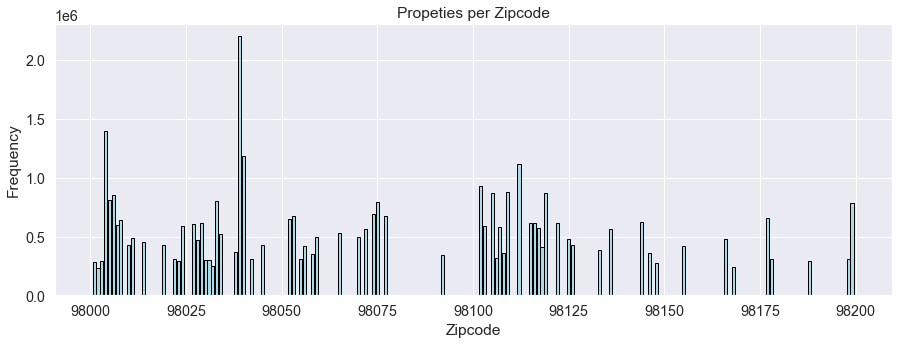

In [365]:
zip_price = df.groupby('zipcode').agg('mean')['price']

fig, ax = plt.subplots(figsize = (15,5))
ax.bar(zip_price.index, zip_price.values ,color='#ADD8E6',edgecolor='black')
# ax.set_xticks(zip_price.index)
# ax.set_xticklabels(zip_price.index, rotation=90)
ax.set_title('Propeties per Zipcode')
ax.set_xlabel('Zipcode')
ax.set_ylabel('Frequency')

We can see that price varies based on Zipcode; this may be an important feature for the model.

# Feature Engineering

In [366]:
df['years_old'] = 2021 - df['yr_built']

In [367]:
df['sqft_yard'] = df['sqft_lot'] - (df['sqft_living']/df['floors'])

### Importing Crime Data

In [368]:
# imported new csv file to get population of each zip code
crime = pd.read_csv('../Phase2Project/data/crimes.csv')
                    
#dropped all irrelevent columns
crime = crime.drop(['case_number','incident_datetime','FCR','address_1','city','state','created_at','updated_at','hour_of_day','day_of_week','Incident Block Location'], axis=1)
crime = crime.rename(columns={'zip':'zipcode'})
crime.head()

,incident_type,zipcode
0,Other,98104
1,Other,98224
2,Vehicle Recovery,98168
3,Traffic,98178
4,Property Crime,98168


In [369]:
#selected columns from each df before merge
crime_count_per_zip = crime.groupby('zipcode').count()
avg_price_per_zip = pd.DataFrame(df.groupby('zipcode').agg('mean')['price'])

In [370]:
#zipcode was default index so reset index and dropped row with string in it
avg_price_per_zip = avg_price_per_zip.reset_index()
crime_count_per_zip = crime_count_per_zip.reset_index()
crime_count_per_zip = crime_count_per_zip.drop(207, axis=0)

In [371]:
#changed object type to int type for merge and then merged
crime_count_per_zip['zipcode'] = crime_count_per_zip['zipcode'].astype(int)
crime_price_df = avg_price_per_zip.merge(crime_count_per_zip, how='left',on='zipcode')

Text(0.5, 1.0, 'Incident Count vs. Price by Zipcode')

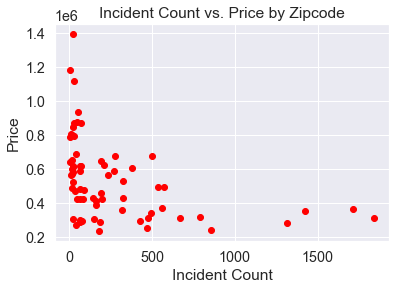

In [372]:
fig, ax = plt.subplots()
ax.scatter(crime_price_df['incident_type'],crime_price_df['price'],c ='red')
ax.set_xlabel('Incident Count')
ax.set_ylabel('Price')
ax.set_title('Incident Count vs. Price by Zipcode')

After plotting incident count vs. price, we can see that as incident rate increases, price decreases. Now, we have to incorporate this data into our original dataframe so we can include it in our model. Let's catergorize this data in terms of high to low crime level.

In [373]:
def crime_level(number):
    if number<=250: 
        return ('low')
    elif number==np.nan:
        return('low')
    elif (number>250) and (number <=600):
        return ('medium') #between 250 and 600
    elif number>600:
        return('high')
        
crime_price_df['crime_rate'] = crime_price_df['incident_type'].map(crime_level)

In [374]:
#drop columns not wanted in merge
crime_to_merge = crime_price_df.drop(['price'], axis=1)

In [375]:
#merge with original df
df = df.merge(crime_to_merge, how='left',on='zipcode')
df = df.rename(columns={'incident_type':'crime_count'})

Text(0.5, 1.0, 'Crime Level vs. AVG Price')

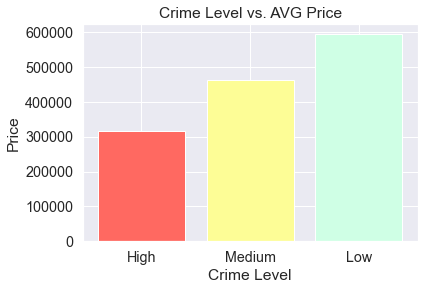

In [376]:
x = df.groupby('crime_rate').agg('mean')['price'].index
y = df.groupby('crime_rate').agg('mean')['price'].values

fig, ax = plt.subplots()
ax.bar(['High','Medium','Low'],[314904.37463127,463542.75972396,593595.52635955],color=['#ff6961','#fdfd96','#cfffe5'])
ax.set_xlabel('Crime Level')
ax.set_ylabel('Price')
ax.set_title('Crime Level vs. AVG Price')



The higher the crime level per Zipcode, the lower the price, which makes sense. Let's run some statistical tests on our data now.

# Statistical Tests

In [377]:
H0_crime = 'Low crime area houses, medium crime area houses, and high crime area houses cost the same.'
H1_crime = 'The null hypothesis is not true.'
alpha = .05
#ANOVA
low_crime_prices = df[df['crime_rate']=='low']['price']
medium_crime_prices = df[df['crime_rate']=='medium']['price']
high_crime_prices = df[df['crime_rate']=='high']['price']
crime_pval = stats.f_oneway(low_crime_prices, medium_crime_prices, high_crime_prices).pvalue
crime_conclusion = 'Because the p-value is less than the alpha, we reject the null hypothesis.'


In [378]:
H0_wf = 'Houses with a waterfront cost the same as houses without.'
H1_wf = 'Houses with a waterfront cost more than houses without.'
alpha = .05
#2 sample t-test
wf = df[df['waterfront']==1]['price']
no_wf = df[df['waterfront']==0]['price']
wf_pval = stats.ttest_ind(wf,no_wf).pvalue

wf_conclusion = 'Because the p-value is less than the alpha, we reject the null hypothesis.'

In [379]:
H0_cond = 'Houses with a condition rating of 4 or 5 cost the same as houses with a condition rating of 1,2, or 3.'
H1_cond = 'Houses with a condition rating of 4 or 5 cost more than houses with a condition rating of 1,2, or 3.'
alpha = .05
#2 sample t-test
good_cond = df[df['condition']>3]['price']
poor_cond = df[df['condition']<4]['price']
cond_pval = stats.ttest_ind(good_cond,poor_cond).pvalue

cond_conclusion = 'Because the p-value is greater than the alpha, we fail to reject the null hypothesis.'
#shows us condition does not have a significant effect on price

In [380]:
H0_old = 'Houses that are older than 30 years cost the same as houses 30 years old and younger.'
H1_old = 'Houses that are older than 30 years cost less than houses 30 years old and younger.'
alpha = .05
#2 sample t-test
new = df[df['years_old']>30]['price']
old = df[df['years_old']<=30]['price']
old_pval = stats.ttest_ind(new,old).pvalue
old_conclusion = 'Because the p-value is less than the alpha, we reject the null hypothesis.'


In [381]:
H0_wf = 'Houses with a waterfront cost the same as houses without.'
H1_wf = 'Houses with a waterfront cost more than houses without.'
alpha = .05
#2 sample t-test
wf = df[df['waterfront']==1]['price']
no_wf = df[df['waterfront']==0]['price']
wf_pval = stats.ttest_ind(wf,no_wf).pvalue

wf_conclusion = 'Because the p-value is less than the alpha, we reject the null hypothesis.'

# Model

Let's run some simple regressions to determine the effect of some variables on Price.

R-squared: 0.42230453039240234


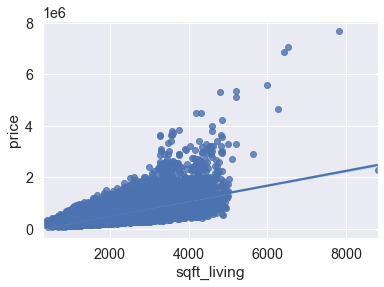

In [382]:
model = ols(formula = "price~sqft_living", data=df).fit()
print(f"R-squared: {model.rsquared}")

sns.regplot(x='sqft_living', y='price', data=df);

R-squared: 0.4438423664493838


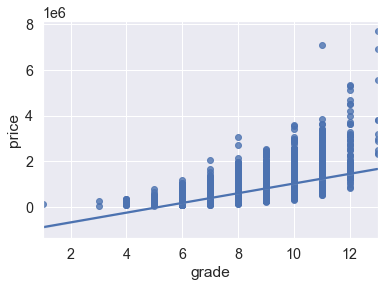

In [383]:
model = ols(formula = "price~grade", data=df).fit()
print(f"R-squared: {model.rsquared}")

sns.regplot(x='grade', y='price', data=df); 

R-squared: 0.2757565323441117


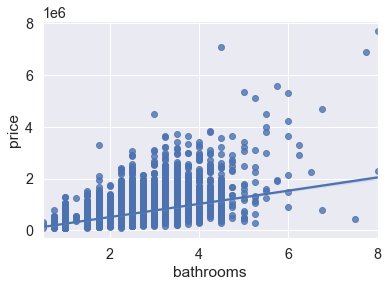

In [384]:
model = ols(formula = "price~bathrooms", data=df).fit()
print(f"R-squared: {model.rsquared}")

sns.regplot(x='bathrooms', y='price', data=df);

R-squared: 0.09845454540161236


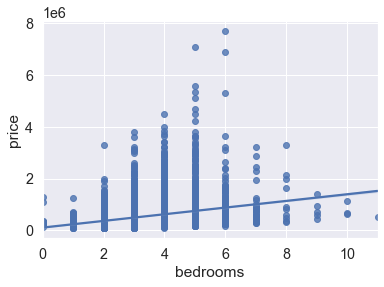

In [385]:
model = ols(formula = "price~bedrooms", data=df).fit()
print(f"R-squared: {model.rsquared}")

sns.regplot(x='bedrooms', y='price', data=df);

Let's run an OLS model and determine our RMSE.

In [386]:
model_df = df[['price','bedrooms','bathrooms','sqft_living','waterfront','grade','zipcode','years_old','crime_rate']]
dummy_df = pd.get_dummies(model_df, columns=['zipcode','waterfront','crime_rate'])
x = dummy_df.drop(columns='price')
y = dummy_df.price

lr = LinearRegression()
hp = lr.fit(x,y)

print(hp.coef_)
print(hp.intercept_)
print(hp.score(x,y))

[-2.27207272e+04  5.99325044e+04  1.40375290e+02  1.00164767e+05
  2.06316418e+03  4.67033757e+13 -2.15958666e+11 -1.29118768e+13
 -2.15957904e+11 -2.15958433e+11 -2.15958424e+11 -2.15958488e+11
 -2.15958455e+11 -2.15958612e+11 -2.15958595e+11 -2.15958563e+11
 -2.15958615e+11 -1.29118768e+13 -2.15958746e+11 -1.29118766e+13
 -1.29118767e+13 -2.15958592e+11 -2.15958534e+11 -2.15958707e+11
 -2.15958698e+11 -1.29118768e+13 -2.15958352e+11 -2.15958511e+11
 -1.29118768e+13 -7.25244721e+13 -2.15958193e+11  4.67033757e+13
 -1.29118767e+13 -2.15958501e+11 -1.29118766e+13 -2.15958667e+11
 -2.15958598e+11  4.67033757e+13 -1.29118767e+13 -1.29118767e+13
 -1.29118768e+13 -2.15958559e+11 -2.15958550e+11 -2.15958542e+11
 -1.29118767e+13 -1.29118769e+13 -2.15958273e+11 -2.15958429e+11
 -2.15958295e+11  4.67033758e+13 -2.15958421e+11 -1.29118767e+13
 -2.15958285e+11 -2.15958154e+11 -2.15958425e+11 -2.15958447e+11
 -2.15958435e+11 -2.15958559e+11 -2.15958283e+11 -2.15958456e+11
 -2.15958531e+11 -2.15958

In [387]:
ols(formula='y~x', data=dummy_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     720.2
Date:                Fri, 12 Mar 2021   Prob (F-statistic):               0.00
Time:                        00:27:04   Log-Likelihood:            -2.3409e+05
No. Observations:               17290   AIC:                         4.683e+05
Df Residuals:                   17214   BIC:                         4.689e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.081e+04   1.14e+04      1.818      0.069   -1626.201    4.33e+04
x[0]       -2.272e+04   2035.158    -11.164      0.000   -2.67e+04   -1.87e+04
x[1]        5.993e+04   3189.440     18.791      0.000    5.37e+04    6.62e+04
x[2]         140.3734      3.424     41.001      0.000     133.663     147.084
x[3]        1.002e+05   2135.160     46.912      0.000     9.6e+04    1.04e+05
x[4]        2063.1676     69.485     29.692      0.000    1926.970    2199.365
x[5]       -9.983e+04   1.02e+04     -9.790      0.000    -1.2e+05   -7.98e+04
x[6]       -1.797e+05   1.46e+04    -12.320      0.000   -2.08e+05   -1.51e+05
x[7]       -1.278e+05    1.2e+04    -10.650      0.000   -1.51e+05   -1.04e+05
x[8]        5.827e+05    1.2e+04     48.677      0.000    5.59e+05    6.06e+05
x[9]        5.369e+04   1.54e+04      3.487      0.000    2.35e+04    8.39e+04
x[10]       6.228e+04   9500.435      6.556      0.000    4.37e+04    8.09e+04
x[11]      -1351.3982   1.64e+04     -0.082      0.935   -3.36e+04    3.09e+04
x[12]       3.136e+04   1.22e+04      2.579      0.010    7520.423    5.52e+04
x[13]      -1.252e+05   2.11e+04     -5.942      0.000   -1.66e+05   -8.39e+04
x[14]      -1.082e+05   1.43e+04     -7.584      0.000   -1.36e+05   -8.03e+04
x[15]      -7.704e+04   1.81e+04     -4.260      0.000   -1.12e+05   -4.16e+04
x[16]      -1.282e+05   1.52e+04     -8.442      0.000   -1.58e+05   -9.84e+04
x[17]       -6.73e+04    1.3e+04     -5.186      0.000   -9.27e+04   -4.19e+04
x[18]      -2.592e+05   9146.364    -28.343      0.000   -2.77e+05   -2.41e+05
x[19]       9.156e+04   2.15e+04      4.252      0.000    4.94e+04    1.34e+05
x[20]       5.065e+04   1.01e+04      5.026      0.000    3.09e+04    7.04e+04
x[21]      -1.057e+05   1.24e+04     -8.557      0.000    -1.3e+05   -8.15e+04
x[22]      -4.743e+04   1.17e+04     -4.058      0.000   -7.03e+04   -2.45e+04
x[23]      -2.209e+05   1.29e+04    -17.099      0.000   -2.46e+05   -1.96e+05
x[24]      -2.115e+05   1.25e+04    -16.920      0.000   -2.36e+05   -1.87e+05
x[25]      -9.715e+04   1.73e+04     -5.621      0.000   -1.31e+05   -6.33e+04
x[26]       1.346e+05   9781.828     13.763      0.000    1.15e+05    1.54e+05
x[27]      -2.435e+04   8882.325     -2.742      0.006   -4.18e+04   -6943.267
x[28]      -7.061e+04   8844.477     -7.984      0.000   -8.79e+04   -5.33e+04
x[29]       9.384e+05   2.26e+04     41.580      0.000    8.94e+05    9.83e+05
x[30]       2.935e+05   1.22e+04     24.039      0.000     2.7e+05    3.17e+05
x[31]      -8.367e+04   8683.893     -9.635      0.000   -1.01e+05   -6.66e+04
x[32]       2580.8127   1.34e+04      0.193      0.847   -2.37e+04    2.88e+04
x[33]      -1.476e+04   8567.801     -1.723      0.085   -3.16e+04    2032.797
x[34]       1.087e+05   1.02e+04     10.605      0.000    8.86e+04    1.29e+05
x[

In [388]:
y_pred = lr.predict(x)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
rmse

183519.1791786148

Text(0, 0.5, 'Predictions')

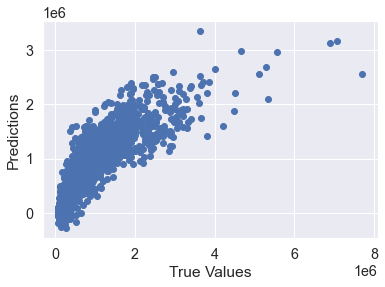

In [389]:
## The line / model
plt.scatter( df['price'], y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

### Plotting Residuals

<AxesSubplot:ylabel='price'>

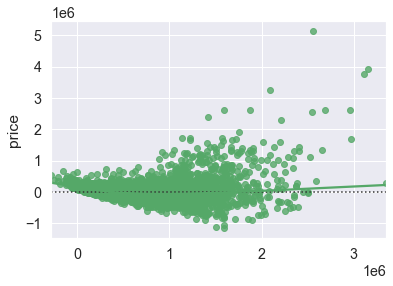

In [390]:
sns.residplot(y_pred, df['price'], lowess=True, color="g")

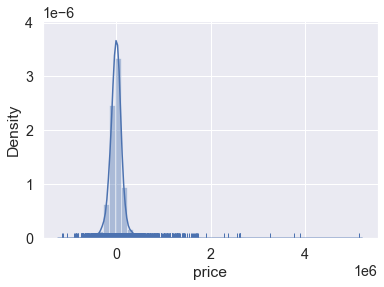

In [391]:
residuals =  df['price']- y_pred
sns.distplot(residuals, kde=True, rug=True);

In [392]:
stats.shapiro(residuals)

ShapiroResult(statistic=0.7092999219894409, pvalue=0.0)

Running the Shapiro test, we were able to see that because the p-value is less than 0.05, we reject the null hypothesis that our residuals are a normal distribution.

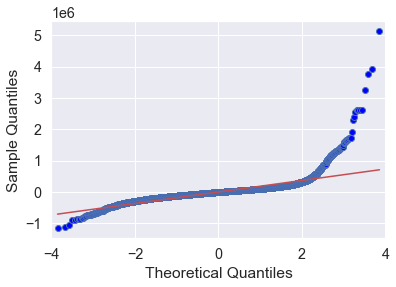

In [393]:
fig = sm.qqplot(residuals,line='s')
plt.show()

To fix this, let's try taking the log of the price.

array([[<AxesSubplot:title={'center':'log_price'}>]], dtype=object)

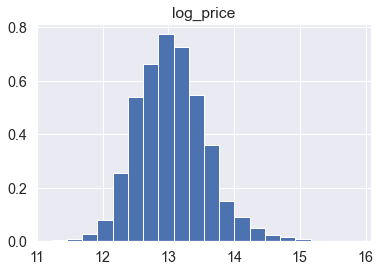

In [394]:
df['log_price'] = np.log(df['price'])
df.hist(column=['log_price'], bins=20, density =True)

<AxesSubplot:ylabel='log_price'>

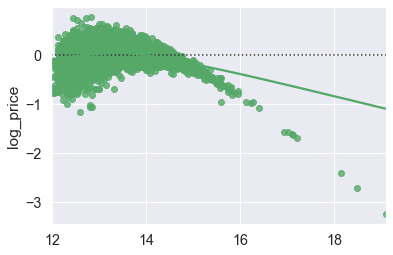

In [395]:
lm_log = LinearRegression()

#fit the linear regression to the data
lm_log.fit(dummy_df, df['log_price'])
y_log_pred = lm_log.predict(dummy_df)

sns.residplot(y_log_pred, df['log_price'], lowess=True, color="g")

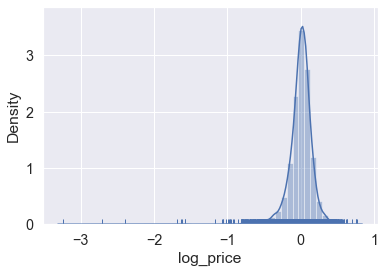

In [396]:
log_residuals =  df['log_price']- y_log_pred
sns.distplot(log_residuals, kde=True, rug=True);

In [397]:
stats.shapiro(log_residuals)

ShapiroResult(statistic=0.8976650238037109, pvalue=0.0)

After taking the log and running the Shapiro test again, we are able to determine our distribution is still not normal.

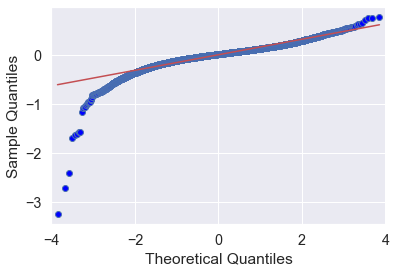

In [398]:
fig = sm.qqplot(log_residuals,line='s')
plt.show()

# Model Evaluation and Selection

#### Log Model

In [399]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(x, y, random_state = 9, test_size=0.2)
    
y_log = np.log(y_train_log)
#instantiate a linear regression object
lm_log = LinearRegression()
#fit the linear regression to the data
lm_log = lm_log.fit(X_train_log, y_log)
log_train_pred  = lm_log.predict(X_train_log)
#log_train_pred the predictions to get them on the same original scale 
y_train_pred_log = np.exp(log_train_pred)
log_train_rmse = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred_log))
    
#use fitted model to predict on the test examples
    
log_test_pred = lm_log.predict(X_test_log)
#get test predictions back to original scale
y_test_pred_log = np.exp(log_test_pred)
    
#evaluate the predictions on the test examples
log_test_rmse = np.sqrt(metrics.mean_squared_error(y_test_log, y_test_pred_log))
    
print('log train_rmse:' + str(log_train_rmse) +' '+ 'log test_rmse:'+  str(log_test_rmse))

log train_rmse:149574.40147137555 log test_rmse:144371.51280466173


### Polynomial Model

In [400]:
features = ['bedrooms','bathrooms','sqft_living','waterfront','grade','zipcode','years_old','crime_rate']
features_df = pd.get_dummies(df[features], columns=['zipcode','waterfront','crime_rate','grade'])
target = df['price']

In [401]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(features_df)
poly2_columns = poly_2.get_feature_names(features_df.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

bedrooms  bathrooms  sqft_living  years_old  zipcode_98001  zipcode_98002  \
0       4.0       2.25       2070.0       35.0            0.0            0.0   
1       5.0       3.00       2900.0       44.0            0.0            0.0   
2       4.0       2.50       3770.0       24.0            0.0            0.0   
3       3.0       3.50       4560.0       31.0            0.0            0.0   
4       3.0       2.50       2550.0       17.0            0.0            0.0   

   zipcode_98003  zipcode_98004  zipcode_98005  zipcode_98006  zipcode_98007  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            1.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98008  zipcode_98010  zipcode_98011  zipcode_98014  zipcode_98019  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98022  zipcode_98023  zipcode_98024  zipcode_98027  zipcode_98028  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98029  zipcode_98030  zipcode_98031  zipcode_98032  zipcode_98033  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98034  zipcode_98038  zipcode_98039  zipcode_98040  zipcode_98042  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            1.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98045  zipcode_98052  zipcode_98053  zipcode_98055  zipcode_98056  \
0            0.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            1.0            0.0            0.0            0.0   

   zipcode_98058  zipcode_98059  zipcode_98065  zipcode_98070  zipcode_98072  \
0            1.0            0.0            0.0            0.0            0.0   
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   zipcode_98074  zipcode_98075  zipcode_98077  zipcode_98092  zipcode_98102  \
0            0.0            0.0            0.0            0.0            0.

In [402]:
len(poly2_columns)

4277

In [403]:
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(df_poly2, target, random_state=9,test_size=0.2)


In [404]:
# instantiate a linear regression object
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(X_train_poly, y_train_poly)

y_train_pred_poly = lm_2.predict(X_train_poly)

train_rmse_poly = np.sqrt(metrics.mean_squared_error(y_train_poly, y_train_pred_poly))

print('Training Root Mean Squared Error:' , train_rmse_poly)

Training Root Mean Squared Error: 119018.75635491799


In [405]:
# use fitted model to predict on test data
y_pred_poly = lm_2.predict(X_test_poly)

test_2rmse = np.sqrt(metrics.mean_squared_error(y_test_poly, y_pred_poly))

print('Testing Root Mean Squared Error:' , test_2rmse)


print('Training: ', int(train_rmse_poly), "vs. Testing: ", int(test_2rmse))

Testing Root Mean Squared Error: 144887.36937590825
Training:  119018 vs. Testing:  144887


### Selection

In [406]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

selector = SelectKBest(f_regression, k=150)

selector.fit(X_train_poly, y_train_poly)

SelectKBest(k=150, score_func=<function f_regression at 0x14f9cc820>)

In [407]:
selected_columns = X_train_poly.columns[selector.get_support()]
removed_columns = X_train_poly.columns[~selector.get_support()]

In [408]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest.fit(X_train_poly[selected_columns], y_train_poly)

y_train_kbest = lm_kbest.predict(X_train_poly[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train_poly, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test_poly[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test_poly, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 164313.45666439773
Testing Root Mean Squared Error: 164418.7021042474


In [409]:
list(zip(selected_columns, lm_kbest.coef_))

[('bedrooms', -18933.08309168473),
 ('bathrooms', 35550.10026434202),
 ('sqft_living', 142.48209306032072),
 ('zipcode_98004', 437177.18235206),
 ('zipcode_98006', -23708.1489883009),
 ('zipcode_98039', 206167.97663011032),
 ('zipcode_98040', 195403.27126513232),
 ('zipcode_98112', 9864.61503606748),
 ('waterfront_0', 60829.262895340515),
 ('waterfront_1', -60829.26274874123),
 ('crime_rate_high', 35681.0167338397),
 ('crime_rate_low', -11524.357016904089),
 ('grade_6', 83639.77485007889),
 ('grade_7', -5969.755721615002),
 ('grade_9', -154075.12037889534),
 ('grade_10', -88259.41293565014),
 ('grade_11', 113497.16611650273),
 ('grade_12', 357856.2123342552),
 ('grade_13', 1054145.8933515984),
 ('bedrooms^2', 1341.0915826960927),
 ('bedrooms bathrooms', 2994.283826158593),
 ('bedrooms sqft_living', -0.6806091357708937),
 ('bedrooms zipcode_98004', -33938.16655196978),
 ('bedrooms zipcode_98006', -4849.788857256435),
 ('bedrooms zipcode_98039', 115242.30064072477),
 ('bedrooms zipcode_9

After running the Polynomial and Interactions Model and using KBest Selection to reduce the number of columns, the testing RMSE (164418.7021042474) is lower than the original model RMSE (183519.1791786148). However, the Log Model gives me the lowest RMSE (144371.51280466173). Therefore, the log model is the one I will use for our Holdout Data.

# Final Model

In [410]:
lm_final = LinearRegression()
lm_final = lm_final.fit(x,np.log(y))


In [411]:
print(lm_final.coef_)
print(lm_final.intercept_)
print(lm_final.score(x,np.log(y)))

[-9.56969206e-03  4.84094947e-02  2.34662728e-04  1.25448449e-01
  1.83529464e-03  7.78637473e+07 -3.60045989e+05 -2.15266478e+07
 -3.60044853e+05 -3.60045246e+05 -3.60045299e+05 -3.60045326e+05
 -3.60045299e+05 -3.60045679e+05 -3.60045520e+05 -3.60045606e+05
 -3.60045613e+05 -2.15266477e+07 -3.60045992e+05 -2.15266473e+07
 -2.15266473e+07 -3.60045544e+05 -3.60045388e+05 -3.60045910e+05
 -3.60045880e+05 -2.15266479e+07 -3.60045197e+05 -3.60045432e+05
 -2.15266476e+07 -1.20912613e+08 -3.60045079e+05  7.78637474e+07
 -2.15266475e+07 -3.60045340e+05 -2.15266472e+07 -3.60045831e+05
 -3.60045633e+05  7.78637474e+07 -2.15266475e+07 -2.15266474e+07
 -2.15266474e+07 -3.60045458e+05 -3.60045418e+05 -3.60045398e+05
 -2.15266474e+07 -2.15266478e+07 -3.60045125e+05 -3.60045220e+05
 -3.60045086e+05  7.78637475e+07 -3.60045202e+05 -2.15266475e+07
 -3.60045077e+05 -3.60045019e+05 -3.60045219e+05 -3.60045251e+05
 -3.60045229e+05 -3.60045560e+05 -3.60045056e+05 -3.60045256e+05
 -3.60045443e+05 -3.60045

In [412]:
import pickle

pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

In [413]:
br_median = df['bathrooms'].median()

In [414]:
pickle_out = open('br_median.pickle', "wb")
pickle.dump(br_median, pickle_out)
pickle_out.close()
